In [ ]:
import pdfplumber
import pandas as pd
from pdfreader import SimplePDFViewer
from bs4 import BeautifulSoup
import requests
from geopy.distance import geodesic
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np




budget_adopted_2023_2024_url = 'https://www.seattleschools.org/wp-content/uploads/2023/09/Budget-Book-Final_Web-Version-Adopted.pdf'
budget_summary_2023_2024_url = 'https://www.seattleschools.org/wp-content/uploads/2023/09/FY24-Adopted-Budget-Summary-Tables.pdf'
budget='budget_adopted_2023_2024.pdf'
budget_summary='budget_summary_2023_2024.pdf'

load_dotenv()

########################################################################################
#   Functions listed here: 
########################################################################################

def get_lat_long(address, api_key):
    url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'results' in data and len(data['results']) > 0:
            location = data['results'][0]['geometry']['location']
            return location['lat'], location['lng']
    return None, None


def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).miles


def extract_tables_from_pdf(pdf_path, page_num):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_num]
        tables = page.extract_tables()
        
        dataframes = []
        for table in tables:
            df = pd.DataFrame(table[1:], columns=table[0])
            dataframes.append(df)
        return dataframes

def find_dataframe_with_column(dfs, column_name):
    for idx, df in enumerate(dfs):
        if column_name in df.columns:
            return idx
    return -1  # Return -1 if the column name is not found in any DataFrame

def extract_text_from_pdf(pdf_path, page_num):
    with open(pdf_path, "rb") as file:
        viewer = SimplePDFViewer(file)
        viewer.navigate(page_num + 1)
        viewer.render()
        return "".join(viewer.canvas.strings)

def get_budget_table(page_num, include_school=True, pivoted=True):
    # First extract the tables from the PDF
    dataframes = extract_tables_from_pdf(budget, page_num)

    # Find the DataFrame that contains the budget table, it varies by page because of nuances with PDFPlumber
    budget_table_index = find_dataframe_with_column(dataframes,'School Year\nFunding Type 21-22 22-23 23-24')
    budget_table_b = dataframes[budget_table_index][[None]][None].str.split(' ', expand=True)
    budget_table_a = dataframes[budget_table_index].iloc[:, 0:1]

    # Overwrite the column names with the correct ones, Merge the two DataFrames    
    budget_table_a.columns = ['Budget']
    budget_table_b.columns = ['2021-22', '2022-23', '2023-24']
    budget_table = pd.merge(budget_table_a, budget_table_b, left_index=True, right_index=True)
    
    
    # Append the string BUDGET to indicate it is the budget data
    budget_table['Budget'] = budget_table['Budget'].apply(lambda x: x + ' (BUDGET)')

    # Clean up the DataFrame and cast numeric values to floats.
    budget_table['2021-22'] = budget_table['2021-22'].str.replace('$', '').str.replace(',', '').astype(float)
    budget_table['2022-23'] = budget_table['2022-23'].str.replace('$', '').str.replace(',', '').astype(float)
    budget_table['2023-24'] = budget_table['2023-24'].str.replace('$', '').str.replace(',', '').astype(float)


    if pivoted: 
        budget_table = budget_table.pivot_table(columns='Budget', values=['2023-24','2022-23','2021-22'], aggfunc='sum') 
        budget_table.columns.name = 'Index'
        budget_table = budget_table.reset_index().rename(columns={'index':'Year'})


    # Find the school name and add it to the DataFrame using a weird string in the PDF to identify the school name
    raw_text = extract_text_from_pdf(budget,page_num)
    if include_school:
        school_name = raw_text[0:raw_text.find('A.2023-24')]
        # Lots of akas for school names in the PDF and website
        if (school_name == 'Cascadia Elementrary'):
            school_name = 'Cascadia Elementary'
        elif (school_name == 'Rising Star Academy'): 
            school_name = 'Rising Star Elementary'
        elif (school_name == 'John Stanford Elementary'): 
            school_name = 'John Stanford International Elementary'
        elif (school_name == 'Northgate Elementary'): 
            school_name = 'James Baldwin Elementary'
        elif (school_name == 'McDonald Intl. Elementary'): 
            school_name = 'McDonald International Elementary'
        elif (school_name == 'Madrona K-5'): 
            school_name = 'Madrona Elementary'
        elif (school_name == 'Martin Luther King Jr. Elementary'): 
            school_name = 'Martin Luther King, Jr. Elementary'
        elif (school_name == 'Genesse Hill Elementary'): 
            school_name = 'Genesee Hill Elementary'
        elif (school_name == 'Dearborn Park Intl. Elementary'): 
            school_name = 'Dearborn Park International Elementary'
        elif (school_name == 'B.F. Day Elementary'): 
            school_name = 'Benjamin Franklin Day Elementary'
        elif (school_name == 'Concord Intl. Elementary'): 
            school_name = 'Concord International Elementary'
        elif (school_name == 'Franz Coe Elementary'): 
            school_name = 'Coe Elementary'
        elif (school_name == 'Beacon Hill Intl. Elementary'): 
            school_name = 'Beacon Hill International Elementary'
        budget_table['School'] = school_name
        col_to_move = budget_table.columns[-1]
        budget_table = budget_table[[col_to_move] + [col for col in budget_table.columns if col != col_to_move]]

    # Reorder the columns, Return the final dataframe
    return budget_table


def get_demographics_table(page_num, include_school=True, pivoted=True):
    # First extract the tables from the PDF
    dataframes = extract_tables_from_pdf(budget, page_num)

    # Find the DataFrame that contains the budget table, it varies by page because of nuances with PDFPlumber
    demographics_table_index = find_dataframe_with_column(dataframes,'School Year\n21-22 22-23 23-24')
    demographics_table_b = dataframes[demographics_table_index][[None]][None].str.split(' ', expand=True)
    demographics_table_a = dataframes[demographics_table_index].iloc[:, 0:1]    

    # Overwrite the column names with the correct ones, Merge the two DataFrames    
    demographics_table_a.columns = ['Demographic']
    demographics_table_b.columns = ['2021-22', '2022-23', '2023-24']
    demographics_table = pd.merge(demographics_table_a, demographics_table_b, left_index=True, right_index=True)

    # Append the string ENROLLMENT to indicate it is the enrollment data
    demographics_table['Demographic'] = demographics_table['Demographic'].apply(lambda x: x + ' (ENROLLMENT)')

    # Find the school name and add it to the DataFrame using a weird string in the PDF to identify the school name
    raw_text = extract_text_from_pdf(budget,page_num)

    if pivoted: 
        demographics_table = demographics_table.pivot_table(columns='Demographic', values=['2023-24','2022-23','2021-22'], aggfunc='sum') 
        demographics_table.columns.name = 'Index'
        demographics_table = demographics_table.reset_index().rename(columns={'index':'Year'})

    if include_school:
        school_name = raw_text[0:raw_text.find('A.2023-24')]
        # Cascadia Elementary is the only school with a typo in the PDF
        if (school_name == 'Cascadia Elementrary'):
            school_name = 'Cascadia Elementary'
        elif (school_name == 'Rising Star Academy'): 
            school_name = 'Rising Star Elementary'
        elif (school_name == 'John Stanford Elementary'): 
            school_name = 'John Stanford International Elementary'
        elif (school_name == 'Northgate Elementary'): 
            school_name = 'James Baldwin Elementary'
        elif (school_name == 'McDonald Intl. Elementary'): 
            school_name = 'McDonald International Elementary'
        elif (school_name == 'Madrona K-5'): 
            school_name = 'Madrona Elementary'
        elif (school_name == 'Martin Luther King Jr. Elementary'): 
            school_name = 'Martin Luther King, Jr. Elementary'
        elif (school_name == 'Genesse Hill Elementary'): 
            school_name = 'Genesee Hill Elementary'
        elif (school_name == 'Dearborn Park Intl. Elementary'): 
            school_name = 'Dearborn Park International Elementary'
        elif (school_name == 'B.F. Day Elementary'): 
            school_name = 'Benjamin Franklin Day Elementary'
        elif (school_name == 'Concord Intl. Elementary'): 
            school_name = 'Concord International Elementary'
        elif (school_name == 'Franz Coe Elementary'): 
            school_name = 'Coe Elementary'
        elif (school_name == 'Beacon Hill Intl. Elementary'): 
            school_name = 'Beacon Hill International Elementary'
        demographics_table['School'] = school_name
        col_to_move = demographics_table.columns[-1]
        demographics_table = demographics_table[[col_to_move] + [col for col in demographics_table.columns if col != col_to_move]]

    # Reorder the columns, Return the final dataframe
    return demographics_table


In [ ]:
########################################################################################
#   Build the Budget Table: 
########################################################################################
x = None

for i in range(67,129): #Pages 67-129 are for elementary schools
    if (x is None):
        x = get_budget_table(i)
    else:
        x = pd.concat([x,get_budget_table(i)], ignore_index=True)
    print(f"{i}, ", end="")
print("done")

In [ ]:
########################################################################################
#   Build the Demographics Table: 
########################################################################################
y = None

for i in range(67,129): #Pages 67-129 are for elementary schools
    if (y is None):
        y = get_demographics_table(i)
    else:
        y = pd.concat([y,get_demographics_table(i)], ignore_index=True)
    print(f"{i}, ", end="")
print("done")

In [ ]:
########################################################################################
#   Get Addresses and Lat/Longs 
########################################################################################
coords = None

for i in range(1,8): 

    # URL of the page to scrape    
    url = f'https://www.seattleschools.org/schools/type/elementary/page/{i}/'

    # Send a request to fetch the webpage content
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception if the request was unsuccessful

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all elements that contain school information
    school_elements = soup.find_all('div', class_='list-item')

    # Prepare lists to store school names and addresses
    schools = []
    addresses = []

    # Loop through each school element to extract names and addresses
    for school_element in school_elements:
        name_element = school_element.find('h4', class_='list-item-title').find('a')
        address_element = school_element.find('address')

        if name_element and address_element:
            school_name = name_element.get_text(strip=True)
            address = address_element.get_text(separator=" ", strip=True)
            
            schools.append(school_name)
            addresses.append(address)

    # Create a DataFrame from the extracted data
    data = {
        'School': schools,
        'Full Address': addresses
    }
    if coords is None:
        coords = pd.DataFrame(data)
    else: 
        coords = pd.concat([coords,pd.DataFrame(data)], ignore_index=True) 

# Remove trailing text from the addresses
api_key = os.getenv('GOOGLE_MAPS_API_KEY')
coords['Full Address'] = coords['Full Address'].apply(lambda x: x[0:x.find('About')])
coords['Latitude'], coords['Longitude'] = zip(*coords['Full Address'].apply(lambda x: get_lat_long(x, api_key)))

In [ ]:
########################################################################################
#   Calculate nearest schools: 
########################################################################################


for index, row in coords.iterrows():
    min_distance = float('inf')
    closest_school = None
    school_coords = (row['Latitude'], row['Longitude'])

    for idx, other_row in coords.iterrows():
        if index != idx:
            other_school_coords = (other_row['Latitude'], other_row['Longitude'])
            distance = calculate_distance(school_coords, other_school_coords)
            if distance < min_distance:
                min_distance = distance
                closest_school = other_row['School']

    coords.at[index, 'Closest School'] = closest_school
    coords.at[index, 'Distance to Closest School (miles)'] = min_distance

In [ ]:
########################################################################################
#   Merge all DFs together, create one as 'z': 
########################################################################################


z = pd.merge(x,y, on=['School','Year'])
z = pd.merge(z,coords, how='left', on='School')

# Calculate helpful additional columns from existing data and cast numeric values to floats
z['Budget Efficiency'] = z['Total Budget (BUDGET)'].astype(float) / z['Total AAFTE* Enrollment (ENROLLMENT)'].astype(float)
z['Total AAFTE* Enrollment (ENROLLMENT)'] = z['Total AAFTE* Enrollment (ENROLLMENT)'].astype(float)

z.to_csv('sps_data_extract.csv', index=False)



In [ ]:
########################################################################################
#   Sandbox and Playground Below: 
########################################################################################

In [ ]:
z[z['School'] == 'Decatur Elementary']

# Group by school and calculate the average budget efficiency
school_performance = z.groupby('School').agg({
    'Budget Efficiency': 'mean',
    '(ENR) Total AAFTE* Enrollment': 'mean',
    '(BDG) Bilingual Education': 'mean',
    '(BDG) Special Education': 'mean',
    '(BDG) General Education': 'mean'
}).reset_index()

# Sort schools by budget efficiency in descending order to identify top-performing schools
top_schools = school_performance.sort_values(by='Budget Efficiency', ascending=False).head(10)
top_schools

In [ ]:
# Calculate the change in enrollment for each school
enrollment_changes = z.pivot_table(index='School', columns='Year', values='(ENR) Total AAFTE* Enrollment')

# Calculate the difference between the first and last year for each school
enrollment_changes['Change'] = enrollment_changes.iloc[:, -1] - enrollment_changes.iloc[:, 0]

# Sort schools by enrollment change in ascending order to find the sharpest decline
sharpest_decline = enrollment_changes.sort_values(by='Change').head(10)

# Sort schools by enrollment change in descending order to find the highest increase
highest_increase = enrollment_changes.sort_values(by='Change', ascending=False).head(10)

sharpest_decline, highest_increase

In [ ]:

# Study of Cascadia Elementary School - which was closed in 2023
cascadia_data = z[z['School'] == 'Cascadia Elementrary']

# Extract relevant columns for Cascadia Elementary
cascadia_summary = cascadia_data[['Year', '(ENR) Total AAFTE* Enrollment', 'Budget Efficiency',
                                  '(BDG) Bilingual Education', '(BDG) Special Education', '(BDG) General Education']]

# Display Cascadia Elementary summary
cascadia_summary

# Detailed trends for Cascadia Elementary

# Calculate year-on-year changes in enrollment and budget efficiency for Cascadia
cascadia_data['Enrollment Change'] = cascadia_data['(ENR) Total AAFTE* Enrollment'].diff()
cascadia_data['Budget Efficiency Change'] = cascadia_data['Budget Efficiency'].diff()

# Calculate year-on-year changes in program funding
cascadia_data['Bilingual Education Change'] = cascadia_data['(BDG) Bilingual Education'].diff()
cascadia_data['Special Education Change'] = cascadia_data['(BDG) Special Education'].diff()
cascadia_data['General Education Change'] = cascadia_data['(BDG) General Education'].diff()

# Display detailed trends
cascadia_data[['Year', '(ENR) Total AAFTE* Enrollment', 'Enrollment Change', 'Budget Efficiency', 'Budget Efficiency Change',
               '(BDG) Bilingual Education', 'Bilingual Education Change', '(BDG) Special Education', 'Special Education Change',
               '(BDG) General Education', 'General Education Change']]

In [ ]:
cascadia_data[['Year', 'Enrollment Change', 'Budget Efficiency Change',
                'Bilingual Education Change', 'Special Education Change',
               'General Education Change']]

In [657]:

########################################################################################
# Prepare data for Clustering Analysis
########################################################################################

data_orig = pd.read_csv('sps_data_extract.csv')

data = data_orig.copy()

data['Bilingual Education (BUDGET)'] = data['Bilingual Education (BUDGET)'].astype(float)
data['General Education (BUDGET)'] = data['General Education (BUDGET)'].astype(float)
data['Other Grants (BUDGET)'] = data['Other Grants (BUDGET)'].astype(float)
data['Special Education (BUDGET)'] = data['Special Education (BUDGET)'].astype(float)
data['State LAP (BUDGET)'] = data['State LAP (BUDGET)'].astype(float)
data['Total Budget (BUDGET)'] = data['Total Budget (BUDGET)'].astype(float)
data['Bilingual Education (ENROLLMENT)'] = data['Bilingual Education (ENROLLMENT)'].astype(float)
data['Free and Reduced Lunch (ENROLLMENT)'] = data['Free and Reduced Lunch (ENROLLMENT)'].astype(float)
data['Special Education (ENROLLMENT)'] = data['Special Education (ENROLLMENT)'].astype(float)
data['Total AAFTE* Enrollment (ENROLLMENT)'] = data['Total AAFTE* Enrollment (ENROLLMENT)'].astype(float)
data['Budget Efficiency'] = data['Budget Efficiency'].astype(float)
data['Distance to Closest School (miles)'] = data['Distance to Closest School (miles)'].astype(float)



# Normalize the numeric data using MinMaxScaler in order to apply K-means clustering fairly on all features
#scaler = MinMaxScaler()
#numeric_df = data.select_dtypes(include=['float64'])
#df_normalized = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
#data = pd.merge(df_normalized, data.drop(columns=numeric_df.columns), left_index=True, right_index=True)



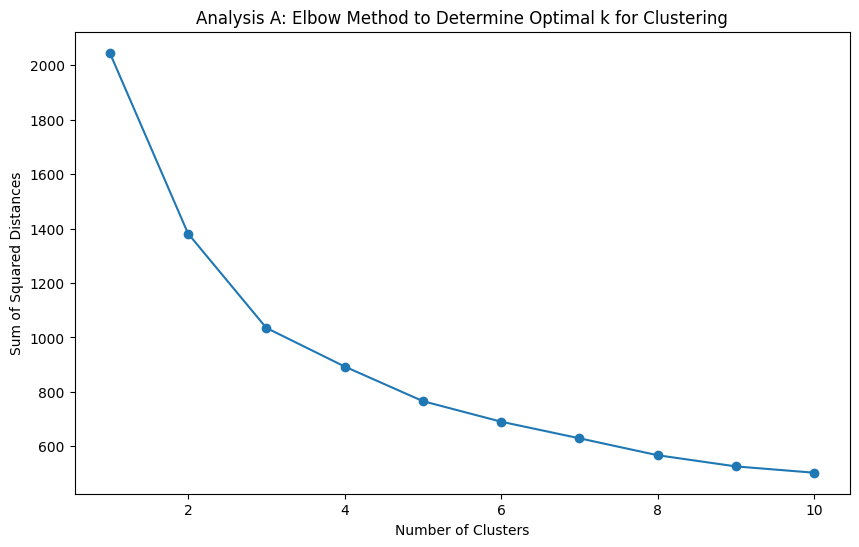

In [658]:
########################################################################################
# Clustering Analysis A: uses all budget and enrollment columns, and budget efficiency
########################################################################################


# Select relevant columns for clustering
columns_to_cluster = [
    'Bilingual Education (BUDGET)', 'General Education (BUDGET)', 'Other Grants (BUDGET)', 
    'Special Education (BUDGET)', 'State LAP (BUDGET)', 'Total Budget (BUDGET)', 
    'Bilingual Education (ENROLLMENT)', 'Free and Reduced Lunch (ENROLLMENT)', 
    'Special Education (ENROLLMENT)', 'Total AAFTE* Enrollment (ENROLLMENT)', 
    'Budget Efficiency'
]

# Handle missing values by filling with the mean of each column
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data[columns_to_cluster])

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Analysis A: Elbow Method to Determine Optimal k for Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()


# Apply K-means clustering with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(data_scaled)

# Apply K-means clustering with k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
clusters_4 = kmeans_4.fit_predict(data_scaled)

# Apply K-means clustering with k=5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(data_scaled)
                                  
# Apply K-means clustering with k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42)
clusters_6 = kmeans_6.fit_predict(data_scaled)


# Add the cluster labels to the original dataframe
data['Cluster_3a'] = clusters_3
data['Cluster_4a'] = clusters_4
data['Cluster_5a'] = clusters_5
data['Cluster_6a'] = clusters_6





In [659]:

# Analyze the clusters by looking at the mean values of the features for each cluster
cluster_3a_summary = data.groupby('Cluster_3a')[columns_to_cluster].mean()
cluster_4a_summary = data.groupby('Cluster_4a')[columns_to_cluster].mean()
cluster_5a_summary = data.groupby('Cluster_5a')[columns_to_cluster].mean()
cluster_6a_summary = data.groupby('Cluster_6a')[columns_to_cluster].mean()

#cluster_3a_summary, cluster_4a_summary, cluster_5a_summary, cluster_6a_summary


In [660]:
########################################################################################
## Observations from Clustering Analysis A: 
########################################################################################


#3 Clusters:
#Cluster 0: Lower budgets and enrollments.
#Cluster 1: Highest budgets and enrollments, especially in bilingual and special education.
#Cluster 2: Moderate budget, high total enrollment.


#4 Clusters:
#Cluster 0: High bilingual education budgets.
#Cluster 1: High budgets and enrollments, significant special education funding.
#Cluster 2: Lower budgets and enrollments.
#Cluster 3: Moderate budgets and enrollments.

#5 Clusters:
#Cluster 0: High overall budgets and enrollments, particularly in general education and other grants.
#Cluster 1: Moderate budgets and enrollments, with a significant amount of state LAP funding.
#Cluster 2: Highest budgets, particularly in special education and state LAP, with high enrollments.
#Cluster 3: High special education funding and enrollment, moderate budgets.
#Cluster 4: Lower budgets and enrollments, with moderate funding in special education and state LAP.

#6 Clusters:
#Cluster 0: High overall budgets and enrollments, with a significant budget for special education and state LAP.
#Cluster 1: Moderate budgets and enrollments, with a notable budget for other grants and a lower budget efficiency.
#Cluster 2: Moderate budgets and enrollments with a focus on bilingual education and state LAP.
#Cluster 3: Higher budgets and enrollments, particularly in special education and state LAP.
#Cluster 4: Highest budgets and enrollments, especially in bilingual education and state LAP.
#Cluster 5: Moderate budgets and enrollments, with a significant budget for other grants and a lower budget efficiency.


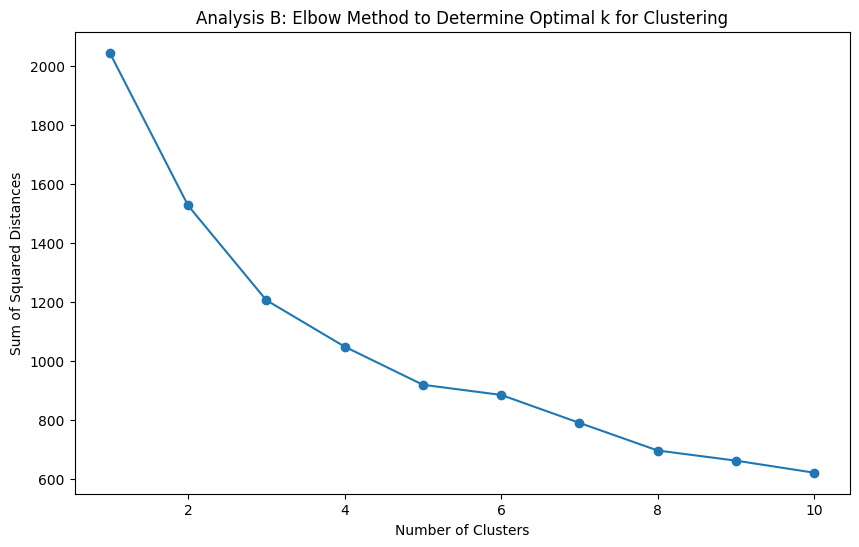

In [661]:
########################################################################################
### Clustering Analysis B: excludes state LAP funding, and includes distance to closest school
########################################################################################

columns_to_cluster = [
    'General Education (BUDGET)', 'Other Grants (BUDGET)', 'Special Education (BUDGET)',
    'Total Budget (BUDGET)', 'Federal Title I (BUDGET)', 'Bilingual Education (ENROLLMENT)',
    'Free and Reduced Lunch (ENROLLMENT)', 'Special Education (ENROLLMENT)',
    'Total AAFTE* Enrollment (ENROLLMENT)', 'Budget Efficiency', 'Distance to Closest School (miles)'
]


# Handle missing values by filling with the mean of each column
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data[columns_to_cluster])

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Analysis B: Elbow Method to Determine Optimal k for Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()




# Apply K-means clustering with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(data_scaled)

# Apply K-means clustering with k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
clusters_4 = kmeans_4.fit_predict(data_scaled)

# Apply K-means clustering with k=5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(data_scaled)
                                  
# Apply K-means clustering with k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42)
clusters_6 = kmeans_6.fit_predict(data_scaled)


# Add the cluster labels to the original dataframe
data['Cluster_3b'] = clusters_3
data['Cluster_4b'] = clusters_4
data['Cluster_5b'] = clusters_5
data['Cluster_6b'] = clusters_6

# Analyze the clusters by looking at the mean values of the features for each cluster
cluster_3b_summary = data.groupby('Cluster_3b')[columns_to_cluster].mean()
cluster_4b_summary = data.groupby('Cluster_4b')[columns_to_cluster].mean()
cluster_5b_summary = data.groupby('Cluster_5b')[columns_to_cluster].mean()
cluster_6b_summary = data.groupby('Cluster_6b')[columns_to_cluster].mean()

#cluster_3b_summary, cluster_4b_summary, cluster_5b_summary, cluster_6b_summary

In [662]:
########################################################################################
## Observations from Clustering Analysis B:
########################################################################################


#3 Clusters:
#Cluster 0: High budgets in General Education and Other Grants, moderate Special Education budget, relatively high Total Budget. Moderate budget efficiency and average distance to the closest school.
#Cluster 1: Moderate budgets across all categories, lower Total Budget. Moderate budget efficiency and slightly higher distance to the closest school.
#Cluster 2: High budgets in General Education, low in Other Grants, high Special Education budget, highest Total Budget. Lowest budget efficiency and shortest distance to the closest school.
# # # Cluster 2 most likely to be targets for closure. 
# # # Cluster 0 most likely not to be closed.

#4 Clusters:
#Cluster 0: High budgets in General Education and Other Grants, moderate Special Education budget, high Total Budget. Moderate budget efficiency and average distance to the closest school.
#Cluster 1: Moderate budgets in General Education, low in Other Grants, moderate Special Education budget, moderate Total Budget. Low budget efficiency and longer distance to the closest school.
#Cluster 2: High budgets in General Education, low in Other Grants, high Special Education budget, highest Total Budget. Low budget efficiency and average distance to the closest school.
#Cluster 3: Low budgets across all categories, lowest Total Budget. Moderate budget efficiency and shortest distance to the closest school.
# # # Clusters 2 and 3 most likely to be targets for closure.
# # # Clusters 0 and 1 likely not to be closed.

#5 Clusters:
#Cluster 0: High budgets in General Education and Other Grants, low Special Education budget, moderate Total Budget. High budget efficiency and moderate distance to the closest school.
#Cluster 1: Moderate budgets in General Education, low in Other Grants, moderate Special Education budget, moderate Total Budget. Low budget efficiency and longer distance to the closest school.
#Cluster 2: High budgets in General Education, moderate in Other Grants, high Special Education budget, high Total Budget. Moderate budget efficiency and average distance to the closest school.
#Cluster 3: Low budgets across all categories, low Total Budget. Moderate budget efficiency and shortest distance to the closest school.
#Cluster 4: High budgets in General Education, low in Other Grants, high Special Education budget, highest Total Budget. Lowest budget efficiency and average distance to the closest school.
# # # Clusters 3 and 4 most likely to be targets for closure.
# # # Clusters 0 and 2 likely not to be closed. 

#6 Clusters:
#Cluster 0: High budgets in General Education and Other Grants, low Special Education budget, moderate Total Budget. High budget efficiency and longer distance to the closest school.
#Cluster 1: Moderate budgets in General Education, low in Other Grants, moderate Special Education budget, moderate Total Budget. Low budget efficiency and longer distance to the closest school.
#Cluster 2: Highest General Education budget, moderate in Other Grants, highest Special Education budget, highest Total Budget. Low budget efficiency and longer distance to the closest school.
#Cluster 3: Low budgets across all categories, lowest Total Budget. Moderate budget efficiency and shortest distance to the closest school. Low budget efficiency and longest distance to the closest school.
#Cluster 4: High budgets in General Education, low in Other Grants, high Special Education budget, high Total Budget. Lowest budget efficiency and average distance to the closest school.
#Cluster 5: High budgets in General Education, low in Other Grants, high Special Education budget, high Total Budget. Moderate budget efficiency and shortest distance to the closest school.
# # # Cluster 4 and 5 most likely to be targets for closure.
# # # Clusters 0 and 2 most likely not to be closed. 


In [663]:
########################################################################################
### Plots for B analysis
########################################################################################



scatter_6 = data[['School','Year','Cluster_6b', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_5 = data[['School','Year','Cluster_5b', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_4 = data[['School','Year','Cluster_4b', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_3 = data[['School','Year','Cluster_3b', 'Distance to Closest School (miles)', 'Budget Efficiency']]

scatter_2023_6b = scatter_6[scatter_6['Year']=='2023-24'].sort_values(by='Cluster_6b')
scatter_2022_6b = scatter_6[scatter_6['Year']=='2022-23'].sort_values(by='Cluster_6b')
scatter_2021_6b = scatter_6[scatter_6['Year']=='2021-22'].sort_values(by='Cluster_6b')

scatter_2023_5b = scatter_5[scatter_5['Year']=='2023-24'].sort_values(by='Cluster_5b')
scatter_2022_5b = scatter_5[scatter_5['Year']=='2022-23'].sort_values(by='Cluster_5b')
scatter_2021_5b = scatter_5[scatter_5['Year']=='2021-22'].sort_values(by='Cluster_5b')

scatter_2023_4b = scatter_4[scatter_4['Year']=='2023-24'].sort_values(by='Cluster_4b')
scatter_2022_4b = scatter_4[scatter_4['Year']=='2022-23'].sort_values(by='Cluster_4b')
scatter_2021_4b = scatter_4[scatter_4['Year']=='2021-22'].sort_values(by='Cluster_4b')

scatter_2023_3b = scatter_3[scatter_3['Year']=='2023-24'].sort_values(by='Cluster_3b')
scatter_2022_3b = scatter_3[scatter_3['Year']=='2022-23'].sort_values(by='Cluster_3b')
scatter_2021_3b = scatter_3[scatter_3['Year']=='2021-22'].sort_values(by='Cluster_3b')




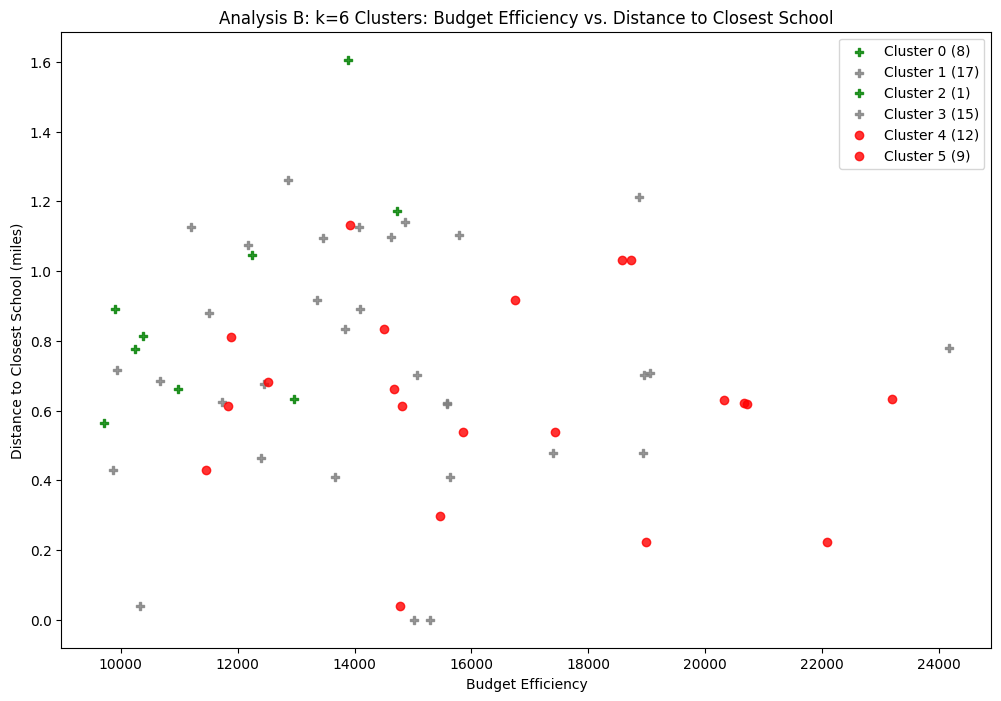

In [664]:
########################################################################################
### K=6 Clusters B Analysis Plot
########################################################################################


df = pd.DataFrame(scatter_2023_6b)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale

cluster_0_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==0].shape[0]
cluster_1_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==1].shape[0]
cluster_2_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==2].shape[0]
cluster_3_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==3].shape[0]
cluster_4_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==4].shape[0]
cluster_5_size = scatter_2023_6b[scatter_2023_6b['Cluster_6b']==5].shape[0]


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
            f'Cluster 3 ({cluster_3_size})',
            f'Cluster 4 ({cluster_4_size})',
            f'Cluster 5 ({cluster_5_size})'
          ]
colors = ['green', 'gray', 'green', 'gray', 'red', 'red']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
#markers = ['o', 's', '^', 'P', 'D', 'X']
markers = ['P', 'P', 'P', 'P', 'o', 'o']

for cluster in range(6):
    cluster_data = df[df['Cluster_6b'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis B: k=6 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()


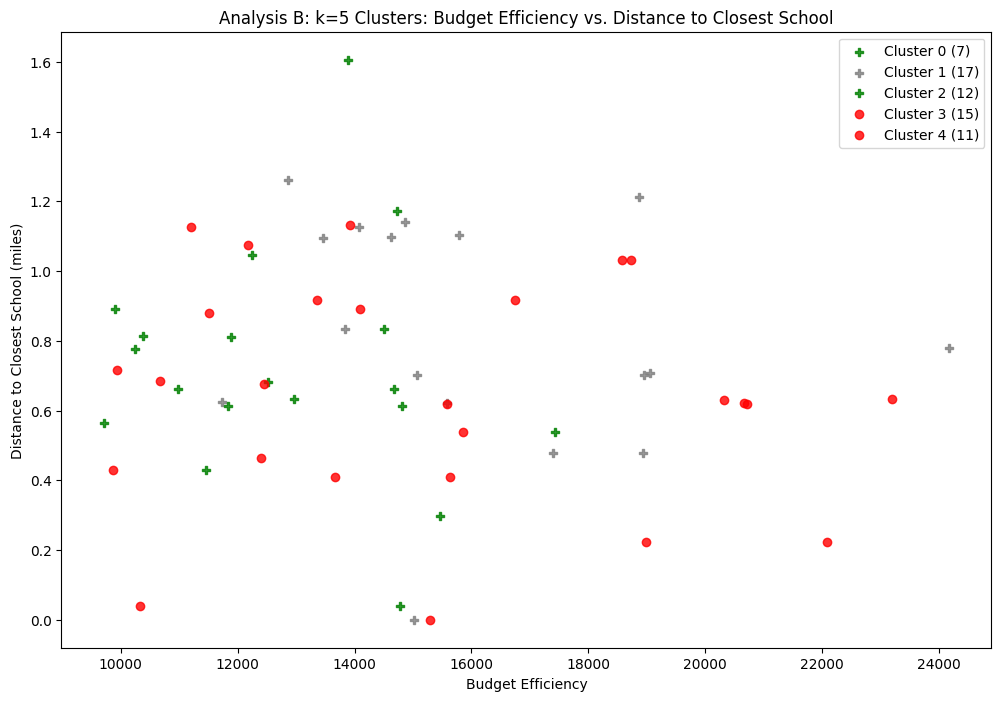

In [665]:
########################################################################################
### K=5 Clusters B Analysis Plot
########################################################################################

df = pd.DataFrame(scatter_2023_5b)

cluster_0_size = scatter_2023_5b[scatter_2023_5b['Cluster_5b']==0].shape[0]
cluster_1_size = scatter_2023_5b[scatter_2023_5b['Cluster_5b']==1].shape[0]
cluster_2_size = scatter_2023_5b[scatter_2023_5b['Cluster_5b']==2].shape[0]
cluster_3_size = scatter_2023_5b[scatter_2023_5b['Cluster_5b']==3].shape[0]
cluster_4_size = scatter_2023_5b[scatter_2023_5b['Cluster_5b']==4].shape[0]


# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
            f'Cluster 3 ({cluster_3_size})',
            f'Cluster 4 ({cluster_4_size})'
          ]
colors = ['green', 'gray', 'green', 'red', 'red']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
markers = ['P', 'P', 'P', 'o', 'o']

for cluster in range(5):
    cluster_data = df[df['Cluster_5b'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8
    )

# Adding labels and title
plt.title('Analysis B: k=5 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

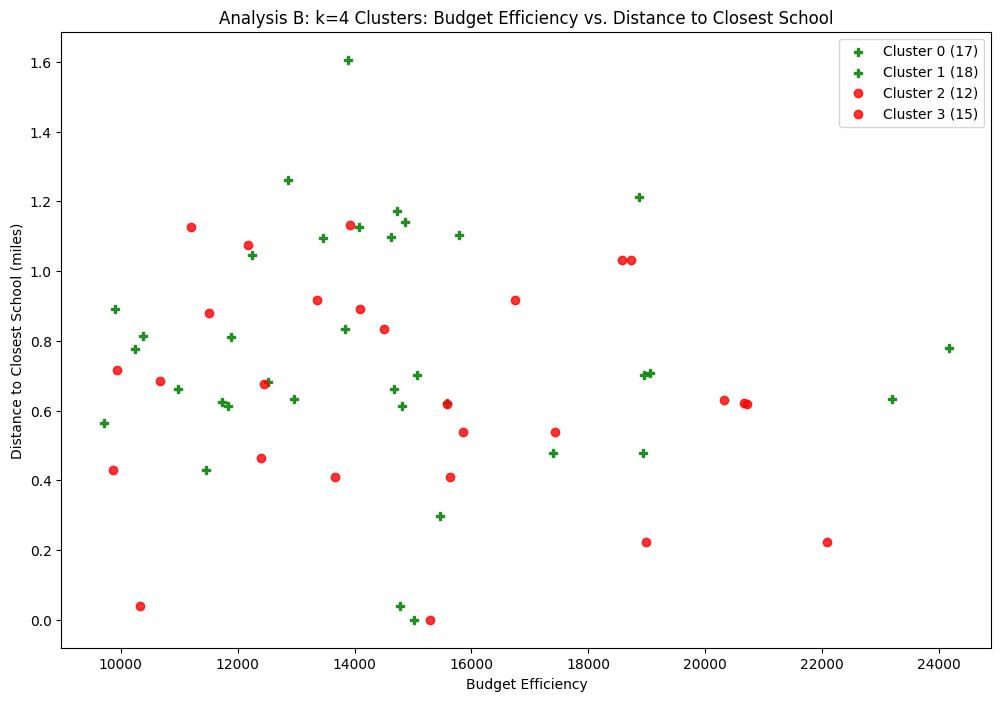

In [666]:
########################################################################################
### K=4 Clusters B Analysis Plot
########################################################################################

df = pd.DataFrame(scatter_2023_4b)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale


cluster_0_size = scatter_2023_4b[scatter_2023_4b['Cluster_4b']==0].shape[0]
cluster_1_size = scatter_2023_4b[scatter_2023_4b['Cluster_4b']==1].shape[0]
cluster_2_size = scatter_2023_4b[scatter_2023_4b['Cluster_4b']==2].shape[0]
cluster_3_size = scatter_2023_4b[scatter_2023_4b['Cluster_4b']==3].shape[0]




labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
            f'Cluster 3 ({cluster_3_size})',
          ]
colors = ['green', 'green', 'red', 'red']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
markers = ['P', 'P', 'o', 'o']

for cluster in range(4):
    cluster_data = df[df['Cluster_4b'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis B: k=4 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

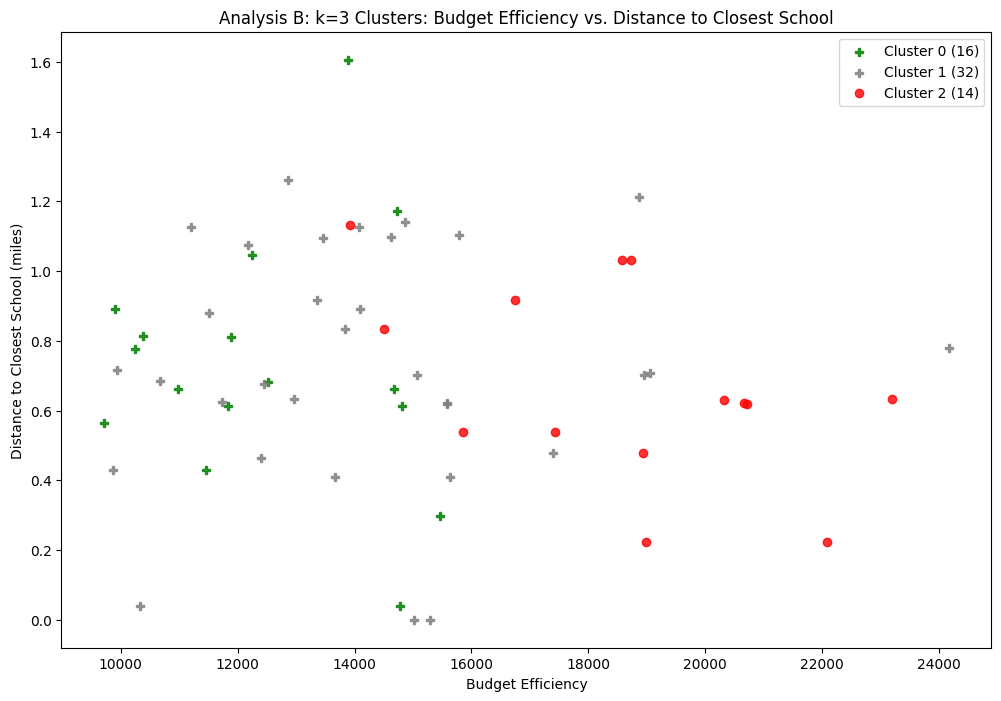

In [667]:

########################################################################################
### K=3 Clusters B Analysis Plot
########################################################################################

df = pd.DataFrame(scatter_2023_3b)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale


cluster_0_size = scatter_2023_3b[scatter_2023_3b['Cluster_3b']==0].shape[0]
cluster_1_size = scatter_2023_3b[scatter_2023_3b['Cluster_3b']==1].shape[0]
cluster_2_size = scatter_2023_3b[scatter_2023_3b['Cluster_3b']==2].shape[0]



labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})'
        ]
colors = ['green', 'gray', 'red']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
markers = ['P', 'P', 'o']

for cluster in range(3):
    cluster_data = df[df['Cluster_3b'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis B: k=3 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

In [668]:
print('List of Schools in k-means k=3 and k=4 identified at risk of closure')
for i in data.query('(Cluster_3b == 2) and (Cluster_4b in (2,3))')['School'].unique().tolist(): 
    print(' - '+i)


List of Schools in k-means k=3 and k=4 identified at risk of closure
 - Dunlap Elementary
 - Emerson Elementary
 - Bailey Gatzert Elementary
 - Kimball Elementary
 - Martin Luther King, Jr. Elementary
 - Lowell Elementary
 - Wing Luke Elementary
 - Maple Elementary
 - Thurgood Marshall Elementary
 - John Muir Elementary
 - Olympic Hills Elementary
 - Rising Star Elementary
 - West Seattle Elementary


In [669]:
print('List of Schools in k-means k=3 and k=4 identified safe from closure')
for i in data.query('(Cluster_3b == 0) and (Cluster_4b in (0,1))')['School'].unique().tolist(): 
    print(' - '+i)

List of Schools in k-means k=3 and k=4 identified safe from closure
 - Adams Elementary
 - Arbor Heights Elementary
 - Daniel Bagley Elementary
 - Bryant Elementary
 - Cascadia Elementary
 - Coe Elementary
 - Benjamin Franklin Day Elementary
 - Fairmount Park Elementary
 - Genesee Hill Elementary
 - Green Lake Elementary
 - Hawthorne Elementary
 - John Hay Elementary
 - Lafayette Elementary
 - Loyal Heights Elementary
 - Thurgood Marshall Elementary
 - McDonald International Elementary
 - North Beach Elementary
 - John Stanford International Elementary
 - Thornton Creek Elementary
 - View Ridge Elementary
 - West Woodland Elementary


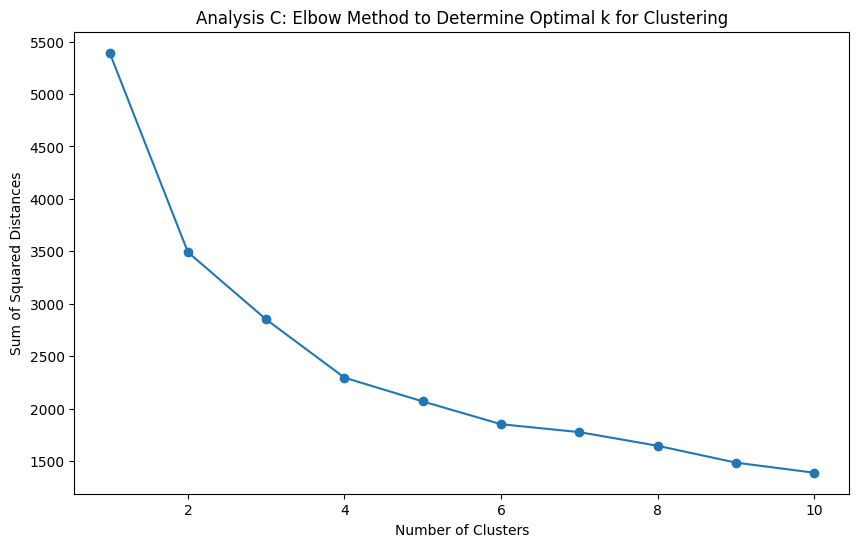

In [683]:
########################################################################################
### Clustering Analysis C: Applying Weights to Features, Same Columns as B Analysis
########################################################################################


columns_to_cluster = [
    'General Education (BUDGET)', 
    'Other Grants (BUDGET)', 
    'Special Education (BUDGET)',
    'Total Budget (BUDGET)', 
    'Federal Title I (BUDGET)', 
    'Bilingual Education (ENROLLMENT)',
    'Free and Reduced Lunch (ENROLLMENT)', 
    'Special Education (ENROLLMENT)',
    'Total AAFTE* Enrollment (ENROLLMENT)', 
    'Budget Efficiency', 
    'Distance to Closest School (miles)'
]

weights = {
    'General Education (BUDGET)':               1, 
    'Other Grants (BUDGET)':                    1, 
    'Special Education (BUDGET)':               1,
    'Total Budget (BUDGET)':                    1, 
    'Federal Title I (BUDGET)':                 1, 
    'Bilingual Education (ENROLLMENT)':         1,
    'Free and Reduced Lunch (ENROLLMENT)':      1, 
    'Special Education (ENROLLMENT)':           1,
    'Total AAFTE* Enrollment (ENROLLMENT)':     1, 
    'Budget Efficiency' :                       2, 
    'Distance to Closest School (miles)':       4

}

imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data[columns_to_cluster])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

i=0
for column, weight in weights.items():
    data_scaled[:,i] *= weight
    i+=1

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Analysis C: Elbow Method to Determine Optimal k for Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()


# Handle missing values by filling with the mean of each column
data_imputed = imputer.fit_transform(data[columns_to_cluster])

# Normalize the data

data_scaled = scaler.fit_transform(data_imputed)
df_scaled = pd.DataFrame(data_scaled, columns=columns_to_cluster)

for column, weight in weights.items():
    df_scaled[column] *= weight

# Apply K-means clustering with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(df_scaled)

# Apply K-means clustering with k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
clusters_4 = kmeans_4.fit_predict(df_scaled)

# Apply K-means clustering with k=5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(df_scaled)
                                  
# Apply K-means clustering with k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42)
clusters_6 = kmeans_6.fit_predict(df_scaled)


# Add the cluster labels to the original dataframe
data['Cluster_3c'] = clusters_3
data['Cluster_4c'] = clusters_4
data['Cluster_5c'] = clusters_5
data['Cluster_6c'] = clusters_6

# Analyze the clusters by looking at the mean values of the features for each cluster
cluster_3c_summary = data.groupby('Cluster_3c')[columns_to_cluster].mean()
cluster_4c_summary = data.groupby('Cluster_4c')[columns_to_cluster].mean()
cluster_5c_summary = data.groupby('Cluster_5c')[columns_to_cluster].mean()
cluster_6c_summary = data.groupby('Cluster_6c')[columns_to_cluster].mean()

#cluster_3c_summary, cluster_4c_summary, cluster_5c_summary, cluster_6c_summary


In [684]:
########################################################################################
## Observations from Clustering Analysis c using weighting: (1,1,1,1,1,1,1,1,1,2,4)
########################################################################################


#3 Clusters:
#Cluster 0: Moderate budgets across all categories, moderate to high enrollment numbers, and below-average budget efficiency, with schools located relatively close to each other.
#Cluster 1: High General Education budgets, average enrollment figures, and moderate budget efficiency, with schools located at greater distances.
#Cluster 2: Highest General Education budgets, lower enrollments, and higher budget efficiency, with schools moderately spaced apart.
# # # Cluster 0 is likely to be target for closure.
# # # Cluster 1 is likely not to be closed. 

#4 Clusters:
#Cluster 0: Lower overall budgets, lower enrollments, and moderate budget efficiency, with schools located very close to each other.
#Cluster 1: High General Education budgets, higher enrollments, and moderate budget efficiency, with schools located at the greatest distances.
#Cluster 2: High General Education budgets, average enrollments, and moderate budget efficiency, with schools moderately spaced apart.
#Cluster 3: Highest Total budgets, high enrollments, and the lowest budget efficiency, with schools located relatively close to each other.
# # # Cluster 0 most likely to be target for closure.
# # # Clusters 1 and 2 likely not to be closed.

#5 Clusters:
#Cluster 0: Lower overall budgets, lower enrollments, and moderate budget efficiency, with schools located very close to each other.
#Cluster 1: High General Education budgets, high enrollments, and moderate budget efficiency, with schools located at the greatest distances.
#Cluster 2: Highest General Education budgets, the highest enrollments, and higher budget efficiency, with schools moderately spaced apart
#Cluster 3: High budgets, higher enrollments, and the lowest budget efficiency, with schools located relatively close to each other
#Cluster 4: Lowest General Education budgets, moderate enrollments, and moderate budget efficiency, with schools moderately spaced apart.
# # # Clusters 0 and 3 most likely to be targets for closure.
# # # Clusters 1 and 2 likely not to be closed. 

#6 Clusters:
#Cluster 0: Lower overall budgets, lower enrollments, and moderate budget efficiency, with schools located very close to each other.
#Cluster 1: Highest Total budgets, highest enrollments, and low budget efficiency, with schools located at the greatest distances
#Cluster 2: High General Education budgets, high enrollments, and the highest budget efficiency, with schools moderately spaced apart.
#Cluster 3: Have high budgets, high enrollments, and the lowest budget efficiency, with schools located relatively close to each other.
#Cluster 4: Moderate budgets, moderate enrollments, and low budget efficiency, with schools moderately spaced apart.
#Cluster 5: Moderate budgets, moderate enrollments, and moderate budget efficiency, with schools located at relatively greater distances.
# # # Clusters 0 and 3 most likely to be targets for closure.
# # # Clusters 1 and 2 most likely not to be closed.

In [687]:
scatter_6 = data[['School','Year','Cluster_6c', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_5 = data[['School','Year','Cluster_5c', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_4 = data[['School','Year','Cluster_4c', 'Distance to Closest School (miles)', 'Budget Efficiency']]
scatter_3 = data[['School','Year','Cluster_3c', 'Distance to Closest School (miles)', 'Budget Efficiency']]

scatter_2023_6c = scatter_6[scatter_6['Year']=='2023-24'].sort_values(by='Cluster_6c')
scatter_2022_6c = scatter_6[scatter_6['Year']=='2022-23'].sort_values(by='Cluster_6c')
scatter_2021_6c = scatter_6[scatter_6['Year']=='2021-22'].sort_values(by='Cluster_6c')

scatter_2023_5c = scatter_5[scatter_5['Year']=='2023-24'].sort_values(by='Cluster_5c')
scatter_2022_5c = scatter_5[scatter_5['Year']=='2022-23'].sort_values(by='Cluster_5c')
scatter_2021_5c = scatter_5[scatter_5['Year']=='2021-22'].sort_values(by='Cluster_5c')

scatter_2023_4c = scatter_4[scatter_4['Year']=='2023-24'].sort_values(by='Cluster_4c')
scatter_2022_4c = scatter_4[scatter_4['Year']=='2022-23'].sort_values(by='Cluster_4c')
scatter_2021_4c = scatter_4[scatter_4['Year']=='2021-22'].sort_values(by='Cluster_4c')

scatter_2023_3c = scatter_3[scatter_3['Year']=='2023-24'].sort_values(by='Cluster_3c')
scatter_2022_3c = scatter_3[scatter_3['Year']=='2022-23'].sort_values(by='Cluster_3c')
scatter_2021_3c = scatter_3[scatter_3['Year']=='2021-22'].sort_values(by='Cluster_3c')

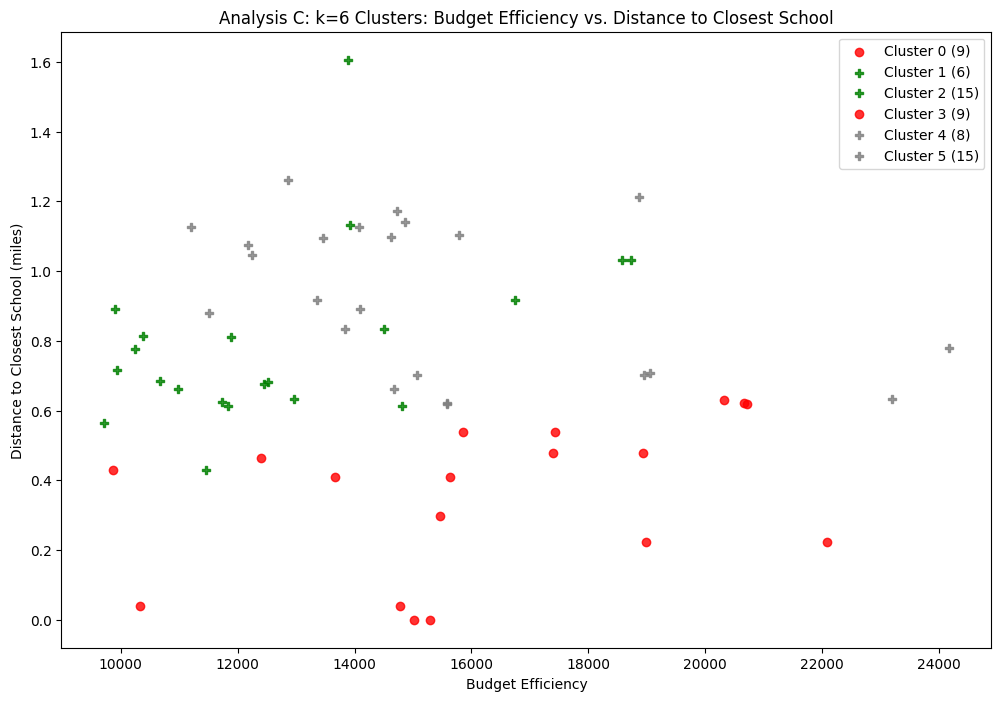

In [688]:
########################################################################################
### K=6 Clusters C Analysis Plot
########################################################################################


df = pd.DataFrame(scatter_2023_6c)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale

cluster_0_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==0].shape[0]
cluster_1_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==1].shape[0]
cluster_2_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==2].shape[0]
cluster_3_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==3].shape[0]
cluster_4_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==4].shape[0]
cluster_5_size = scatter_2023_6c[scatter_2023_6c['Cluster_6c']==5].shape[0]


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
          f'Cluster 3 ({cluster_3_size})',
          f'Cluster 4 ({cluster_4_size})',
          f'Cluster 5 ({cluster_5_size})'
          ]
colors = ['red', 'green', 'green', 'red', 'gray', 'gray']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
#markers = ['o', 's', '^', 'P', 'D', 'X']
markers = ['o', 'P', 'P', 'o', 'P', 'P']

for cluster in range(6):
    cluster_data = df[df['Cluster_6c'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis C: k=6 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()


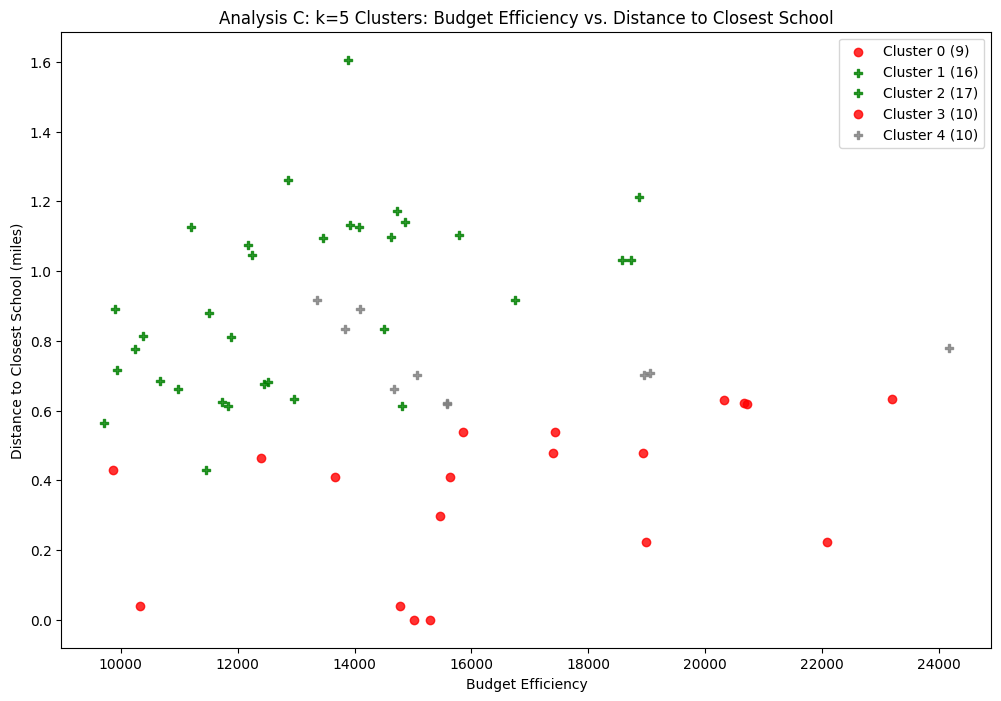

In [689]:
########################################################################################
### K=5 Clusters C Analysis Plot
########################################################################################


df = pd.DataFrame(scatter_2023_5c)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale

cluster_0_size = scatter_2023_5c[scatter_2023_5c['Cluster_5c']==0].shape[0]
cluster_1_size = scatter_2023_5c[scatter_2023_5c['Cluster_5c']==1].shape[0]
cluster_2_size = scatter_2023_5c[scatter_2023_5c['Cluster_5c']==2].shape[0]
cluster_3_size = scatter_2023_5c[scatter_2023_5c['Cluster_5c']==3].shape[0]
cluster_4_size = scatter_2023_5c[scatter_2023_5c['Cluster_5c']==4].shape[0]


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
            f'Cluster 3 ({cluster_3_size})',
            f'Cluster 4 ({cluster_4_size})'
          ]
colors = ['red', 'green', 'green', 'red', 'gray']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
#markers = ['o', 's', '^', 'P', 'D', 'X']
markers = ['o', 'P', 'P', 'o', 'P']

for cluster in range(5):
    cluster_data = df[df['Cluster_5c'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis C: k=5 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

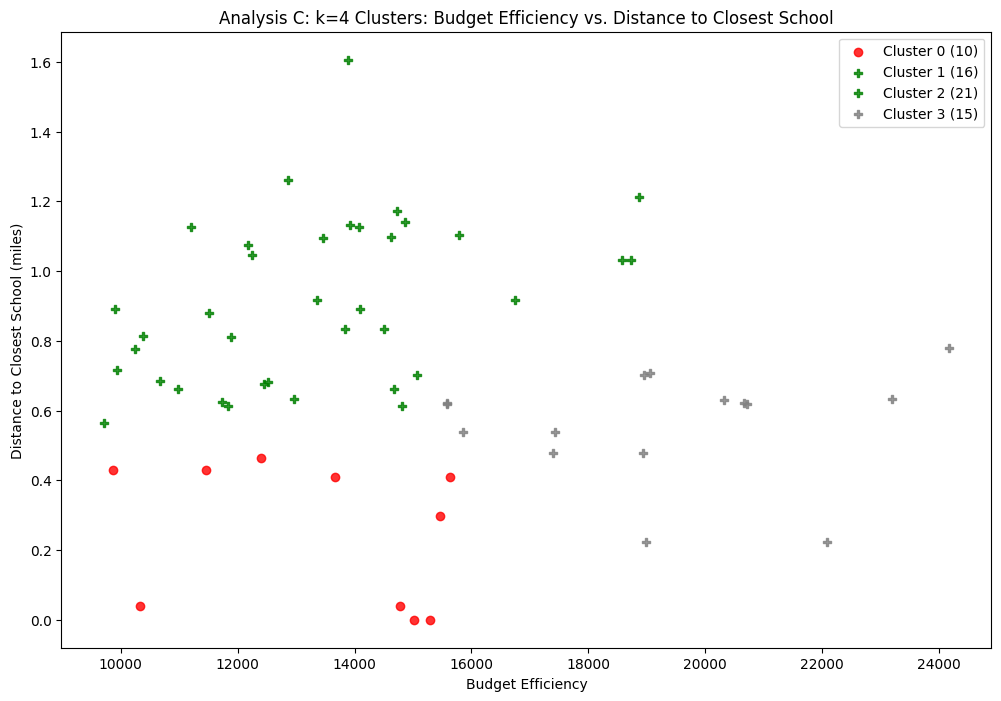

In [690]:
########################################################################################
### K=4 Clusters C Analysis Plot
########################################################################################


df = pd.DataFrame(scatter_2023_4c)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale

cluster_0_size = scatter_2023_4c[scatter_2023_4c['Cluster_4c']==0].shape[0]
cluster_1_size = scatter_2023_4c[scatter_2023_4c['Cluster_4c']==1].shape[0]
cluster_2_size = scatter_2023_4c[scatter_2023_4c['Cluster_4c']==2].shape[0]
cluster_3_size = scatter_2023_4c[scatter_2023_4c['Cluster_4c']==3].shape[0]
cluster_4_size = scatter_2023_4c[scatter_2023_4c['Cluster_4c']==4].shape[0]


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})', 
            f'Cluster 3 ({cluster_3_size})'
          ]
colors = ['red', 'green', 'green', 'gray']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
#markers = ['o', 's', '^', 'P', 'D', 'X']
markers = ['o', 'P', 'P', 'P']

for cluster in range(4):
    cluster_data = df[df['Cluster_4c'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis C: k=4 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

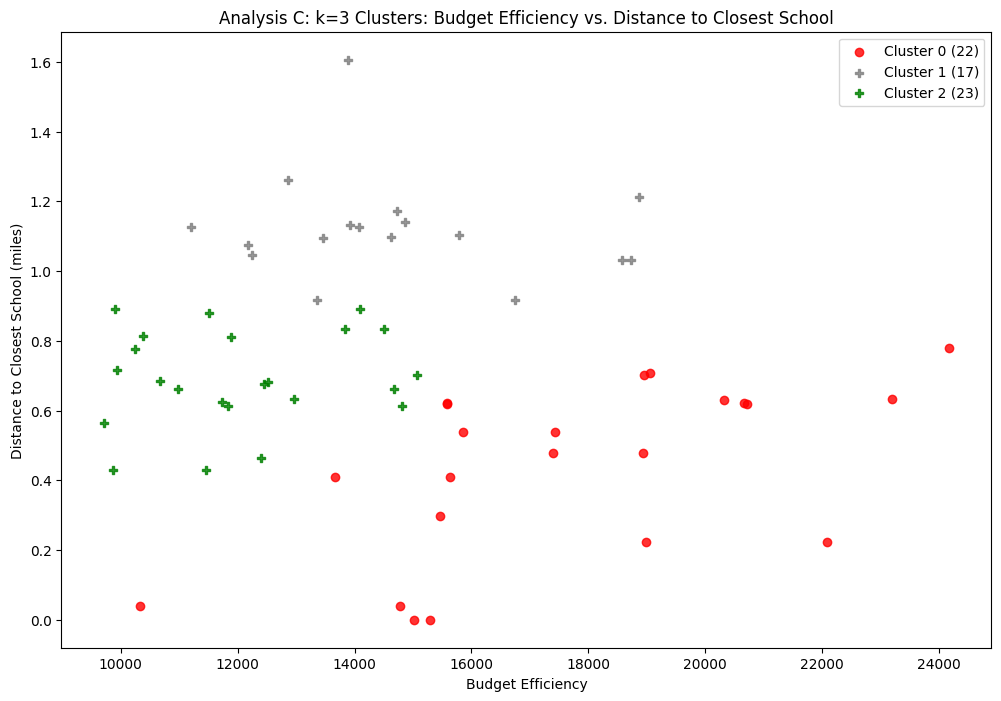

In [691]:
########################################################################################
### K=3 Clusters C Analysis Plot
########################################################################################


df = pd.DataFrame(scatter_2023_3c)

# Function to add jitter
def add_jitter(arr, scale=0.01):
    return arr + np.random.randn(len(arr)) * scale

cluster_0_size = scatter_2023_3c[scatter_2023_3c['Cluster_3c']==0].shape[0]
cluster_1_size = scatter_2023_3c[scatter_2023_3c['Cluster_3c']==1].shape[0]
cluster_2_size = scatter_2023_3c[scatter_2023_3c['Cluster_3c']==2].shape[0]


labels = [
          f'Cluster 0 ({cluster_0_size})', 
          f'Cluster 1 ({cluster_1_size})', 
          f'Cluster 2 ({cluster_2_size})'
          ]
colors = ['red', 'gray', 'green']


# Plotting the k=6 clusters with enhancements
plt.figure(figsize=(12, 8))

# Marker styles
#markers = ['o', 's', '^', 'P', 'D', 'X']
markers = ['o', 'P', 'P']

for cluster in range(3):
    cluster_data = df[df['Cluster_3c'] == cluster]
    plt.scatter(
        cluster_data['Budget Efficiency'], #add_jitter(cluster_data['Budget Efficiency'], 100), 
        cluster_data['Distance to Closest School (miles)'], #add_jitter(cluster_data['Distance to Closest School (miles)'], 0.01),
        color=colors[cluster],
        marker=markers[cluster],
        label=labels[cluster],
        alpha=0.8

    )

# Adding labels and title
plt.title('Analysis C: k=3 Clusters: Budget Efficiency vs. Distance to Closest School')
plt.xlabel('Budget Efficiency')
plt.ylabel('Distance to Closest School (miles)')

# Creating a legend
plt.legend()

plt.show()

In [692]:
print('Analysis C: List of Schools in k-means k=3 and k=4 identified at risk of closure')
for i in data.query('(Cluster_3c == 0) and (Cluster_4c == 0)')['School'].unique().tolist(): 
    print(' - '+i)

Analysis C: List of Schools in k-means k=3 and k=4 identified at risk of closure
 - Decatur Elementary
 - Green Lake Elementary
 - John Hay Elementary
 - Montlake Elementary
 - Queen Anne Elementary
 - John Rogers Elementary
 - Thornton Creek Elementary


In [693]:
print('Analysis C: List of Schools in k-means k=3 and k=4 identified safe from closure')
for i in data.query('(Cluster_3c == 1) and (Cluster_4c in (1,2))')['School'].unique().tolist(): 
    print(' - '+i)

Analysis C: List of Schools in k-means k=3 and k=4 identified safe from closure
 - Arbor Heights Elementary
 - Cedar Park Elementary
 - Concord International Elementary
 - Benjamin Franklin Day Elementary
 - Dearborn Park International Elementary
 - Emerson Elementary
 - Bailey Gatzert Elementary
 - Highland Park Elementary
 - Lawton Elementary
 - Magnolia Elementary
 - Maple Elementary
 - McGilvra Elementary
 - James Baldwin Elementary
 - Olympic Hills Elementary
 - Rainier View Elementary
 - Viewlands Elementary
 - West Woodland Elementary
